In [1]:
import sys
from pathlib import Path

sys.path.append(str(Path.cwd().parent.parent))

In [2]:
from poi.gp import gp_model
from poi.poi import probability_of_improvement, POI
from poi.utils import sample_standard_simplex

In [3]:
import numpy as np
from scipy.stats import norm, multivariate_normal

from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt
from matplotlib import cm

# Test Function

Test POI on a test objective function.

In [4]:
f = lambda x, y: (x**2 + y**2)*np.sin(np.pi*x*y/16)
fvect = np.vectorize(f)

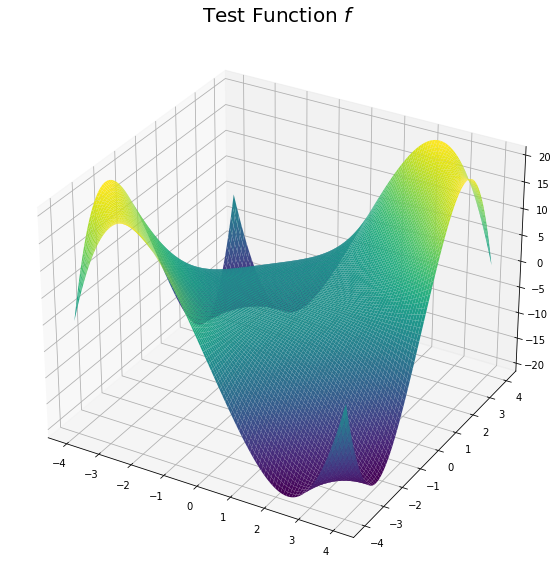

In [5]:
fig = plt.figure(figsize=(10,10))
ln = np.linspace(-4,4,100)[:,None]
x, y = np.meshgrid(ln, ln)

ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(x, y, fvect(x,y), rstride=1, cstride=1, cmap=cm.viridis)
ax.set_title(r'Test Function $f$',fontsize=20);

# Data

Generate data.

In [6]:
d = 2 # dimension

In [7]:
N = 500 # number of points in dataset

In [8]:
noise = 0.5 # noising function values

In [9]:
mu = np.zeros(d)
sigma = np.diag(d*sample_standard_simplex(d))
X = multivariate_normal(mean=mu,cov=sigma).rvs(size=N)

In [10]:
y = fvect(X[:,0],X[:,1]) + norm(loc=0,scale=noise).rvs(size=X.shape[0])
y = y[:,None]

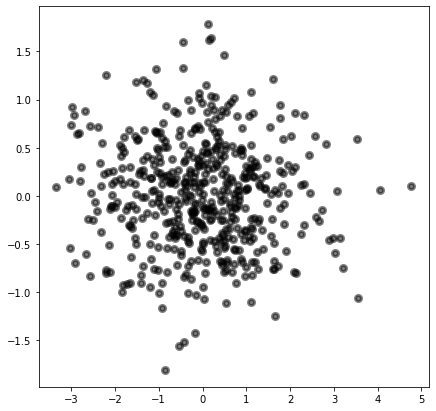

In [11]:
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot()

ax.scatter(X[:,0],X[:,1],color='black',alpha=0.5,lw=3);

# GP 

**Gaussian process model.**

is_mcmc: True to use HMC to optimize kernel hyper-parameters.<br>
num_samples: number of samples in an MC chain.<br>
hmc_iters: number of MC chains to sample.<br>
plot_kernel_posteriors: True to plot kernel hyper-parameter posteriors when using HMC.

In [12]:
model = gp_model(X,y)
# model = gp_model(X,y,is_mcmc=True,num_samples=1000,hmc_iters=3,plot_kernel_posteriors=True)

**Test GP prediction at the origin.**

In [13]:
mu_at0, sigma_at0 = model.predict(np.array([[0.,0.]]))
mu_at0, sigma_at0 = mu_at0[0][0], sigma_at0[0][0]
print('mu at the origin: {:.3f}'.format(mu_at0))
print('sigma at the origin: {:.3f}'.format(sigma_at0))

mu at the origin: -0.012
sigma at the origin: 0.259


# POI 

Calculate POI for constraint satisfaciton: $$\Pr[f(x') < t]$$.

**solution**: proposed optimal solution $x'$.<br>
**reference**: proposed threshold $t$ for constraint satisfaction.

In [14]:
solutions = np.array([[2.,2.],[1.,1.],[3.,3.]])
references = np.array([[5.,6.,7.]])

**True values of proposed solutions.**

In [15]:
fvect(solutions[:,0],solutions[:,1])

array([ 5.65685425,  0.39018064, 17.65413505])

**Predicted means values of proposed solutions.**

In [16]:
model.predict(solutions)[0].flatten()

array([3.20884575, 0.48061771, 6.98370939])

In [17]:
probability_of_improvement(solutions,references,model,is_constraint=True)

[POI(solution=array([2., 2.]), reference=array([5.]), probability=0.88357, is_minimum=True),
 POI(solution=array([2., 2.]), reference=array([6.]), probability=0.96831, is_minimum=True),
 POI(solution=array([2., 2.]), reference=array([7.]), probability=0.99442, is_minimum=True),
 POI(solution=array([1., 1.]), reference=array([5.]), probability=1.0, is_minimum=True),
 POI(solution=array([1., 1.]), reference=array([6.]), probability=1.0, is_minimum=True),
 POI(solution=array([1., 1.]), reference=array([7.]), probability=1.0, is_minimum=True),
 POI(solution=array([3., 3.]), reference=array([5.]), probability=0.37892, is_minimum=True),
 POI(solution=array([3., 3.]), reference=array([6.]), probability=0.43772, is_minimum=True),
 POI(solution=array([3., 3.]), reference=array([7.]), probability=0.50252, is_minimum=True)]

# POI 

Calculate POI for improvement: $$\Pr[f(x') < f(x_0)]$$.

**solution**: proposed optimal solution $x'$.<br>
**reference**: proposed policy $x_0$ to compare.

In [18]:
solutions = np.array([[1.,1.],[3.,3.]])
references = np.array([[2.,2.]])

**True values of proposed solutions.**

In [19]:
fvect(solutions[:,0],solutions[:,1])

array([ 0.39018064, 17.65413505])

**Predicted means values of proposed solutions.**

In [20]:
model.predict(solutions)[0].flatten()

array([0.48061771, 6.98370939])

**True values of references.**

In [21]:
fvect(references[:,0],references[:,1])

array([5.65685425])

**Predicted means values of references.**

In [22]:
model.predict(references)[0].flatten()

array([3.20884575])

[POI(solution=array([1., 1.]), reference=array([2., 2.]), probability=0.95971, is_minimum=True),
 POI(solution=array([3., 3.]), reference=array([2., 2.]), probability=0.23047, is_minimum=True)]

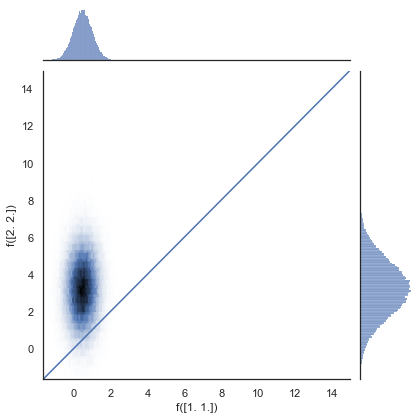

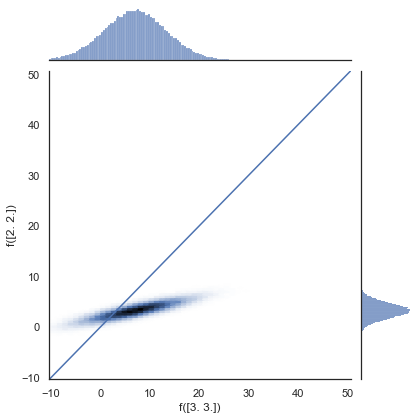

In [23]:
probability_of_improvement(solutions,references,model,plot_joint_gaussians=True)